In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import multiprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import auc

In [2]:
def make_node_df(G):
    nodes = {}
    for node, attribute in G.nodes(data=True):
        if not nodes.get('node'):
            nodes['node'] = [node]
        else:
            nodes['node'].append(node)

        for key, value in attribute.items():
            if not nodes.get(key):
                nodes[key] = [value]
            else:
                nodes[key].append(value)

    return pd.DataFrame(nodes)

def make_edge_df(G):
    edges = {}
    for source, target, attribute in G.edges(data=True):

        if not edges.get('source'):
            edges['source'] = [source]
        else:
            edges['source'].append(source)

        if not edges.get('target'):
            edges['target'] = [target]
        else:
            edges['target'].append(target)

        for key, value in attribute.items():
            if not edges.get(key):
                edges[key] = [value]
            else:
                edges[key].append(value)
    return pd.DataFrame(edges)

In [3]:
G=nx.read_gexf('final_net.gexf')
G.number_of_nodes()
df=make_node_df(G)
links=make_edge_df(G)

# Extract a sample for Test

In [4]:
df_sample = df.sample(frac = 0.01, axis = "index")
# for real data do: df_sample = df.sample(frac = 0.1, axis = "index") # frac is the fraction of rows nodes to start with
df_sample

,node,category,label
154,16909343,proukr,16909343
2016,278603601,proukr,278603601
7193,1059884007171620864,proukr,1059884007171620864
8600,1322584858804277248,proukr,1322584858804277248
3755,1497051931,dontcare,1497051931
...,...,...,...
5133,3468216737,proukr,3468216737
9287,1429890854345379844,proukr,1429890854345379844
2625,434275853,proukr,434275853
4480,2680539031,proukr,2680539031


In [5]:
df_sample_set = set(df_sample["node"])

In [6]:
# linkage step: now i need to only take the links that are from or to a node included in the sample.
# these links are the "chosen links"
# second step is take the nodes that "chosen links" point to or come from (same thing) and add these nodes to the set
# end.
# if i then repeat the "linkage step", i would get gradually a bigger net until i eventually get all the net.
# therefore I just end where I end (after only one "linkage step" and one addition of "chosen links")
# mindful that this subnet as composed does not include all links originating from nodes in the subnet.
# therefore I'm not sure if this approach is sound or not. Can't think of a better one, though.


In [7]:
g_test = nx.Graph()
g_test.add_nodes_from(df_sample_set)
g_test.nodes

NodeView(('242893061', '48000357', '1429081006041178116', '53199373', '797250788825382912', '2847906743', '2680539031', '822583656820699136', '1389968815535054853', '1107926314579869697', '787403334558900224', '3198802391', '1469332931130834952', '806839555', '296774254', '1149747295', '19418649', '1192678393419980800', '1500028669980557314', '1345645611882864641', '1478807288886538240', '617772546', '3010907035', '1429890854345379844', '2513476004', '1129351184962248704', '147476990', '20728264', '3468216737', '289402377', '1497051931', '537837123', '1090270096948248576', '1355726575648403458', '19399022', '1178259103346499584', '2437761697', '1238296287998590982', '1451169754119647235', '1028247846812901381', '766741444212195329', '1427597810103472162', '1375906402993111051', '4683509736', '1237214520012967936', '826823477600583680', '1185239169007792128', '512567648', '1179783761766096896', '1079410802803781634', '1438963299148775428', '16311161', '1328213293475930112', '1263960926'

In [8]:
#while g.edges>=len(df)*20/100
for node in g_test.nodes:
    #print(f"Working on {node}")

    one = links[links["source"] == node]
    two = links[links["target"] == node]
    subset_of_links = pd.concat((one, two))
    #if len(subset_of_links) > 1:
        #print(f"We found {len(subset_of_links)} links")

    if not subset_of_links.empty:
        new_graph = nx.from_pandas_edgelist(subset_of_links)
        g_test = nx.compose(g_test, new_graph)

In [9]:
#g.nodes

In [10]:
#g.edges

In [11]:
len(g_test.nodes)

285

In [12]:
len(g_test.edges)

236

In [13]:
len(df_sample)

102

In [14]:
g_test.remove_edges_from(list(nx.selfloop_edges(g_test))) #rimuovere selfloops
g_test.remove_nodes_from(list(nx.isolates(g_test)))       #rimuovere nodi isolati

#nx.draw(g_test)
print('TEST')
print('number of nodes = {} \n'
    'number of edges = {}'.format(g_test.number_of_nodes(), g_test.number_of_edges()))

TEST
number of nodes = 285 
number of edges = 236


## train_sample

In [15]:
#create train
df_train = pd.concat([df,df_sample]).drop_duplicates(keep=False)
df_train

,node,category,label
0,290883,pax,290883
1,1471971,proukr,1471971
2,2052911,pax,2052911
3,2827221,dontcare,2827221
4,3688111,proukr,3688111
...,...,...,...
10179,1502695274241826818,pax,1502695274241826818
10180,1502720034971521026,proukr,1502720034971521026
10181,1502799611379036163,prorus,1502799611379036163
10182,1502964238033297408,proukr,1502964238033297408


In [16]:
df_train_sample = df_train.sample(frac = 0.05, axis = "index")

In [17]:
df_sample_train_set = set(df_train_sample["node"])

In [18]:
G_train = nx.Graph()
G_train.add_nodes_from(df_sample_train_set)
G_train.nodes

NodeView(('3336987819', '1447380810408005634', '1252997479', '2442672558', '1485388309362790405', '1150093577256603648', '797442530438692864', '18954472', '1273661910', '3017901893', '1254209545662013440', '1481369987726069761', '946479091393486848', '312633500', '1372675463483695114', '794519571294261248', '22041669', '911937330', '14118020', '272152883', '411295303', '257268909', '134601375', '1499201862456778753', '1177583243887091712', '1475529749627875335', '17001893', '123536206', '485063569', '529991739', '993617920147079170', '999759383830679553', '283708433', '1477316626768924674', '37866989', '839669114578747392', '885974198719533057', '126899523', '100469505', '22875032', '535183753', '1325231934314721281', '2839517127', '325570275', '45890260', '250030126', '2705021885', '480680299', '804424518899007494', '792200936605310976', '2206800207', '1307368264167755780', '1175171465827823618', '1336007929758175232', '49697422', '1276416237669670913', '513534321', '292061074', '9626

In [19]:
#while g.edges>=len(df)*20/100
for node in G_train.nodes:
    #print(f"Working on {node}")

    one = links[links["source"] == node]
    two = links[links["target"] == node]
    subset_of_links = pd.concat((one, two))
    #if len(subset_of_links) > 1:
        #print(f"We found {len(subset_of_links)} links")

    if not subset_of_links.empty:
        new_graph = nx.from_pandas_edgelist(subset_of_links)
        G_train = nx.compose(G_train, new_graph)

In [20]:
len(G_train.nodes())

1048

In [21]:
len(G_train.edges())

1008

In [22]:
G_train.remove_edges_from(list(nx.selfloop_edges(G_train))) #rimuovere selfloops
G_train.remove_nodes_from(list(nx.isolates(G_train)))       #rimuovere nodi isolati
#nx.draw(G_train)
print('TRAIN')
print('number of nodes = {} \n'
    'number of edges = {}'.format(G_train.number_of_nodes(), G_train.number_of_edges()))

TRAIN
number of nodes = 1048 
number of edges = 1008


# Link prediction

In [25]:
import linkpred
%matplotlib inline 

In [26]:
cn = linkpred.predictors.CommonNeighbours(G_train, excluded=G_train.edges()) # We aim to predict only new links, thus we exclude existing ones
cn_results = cn.predict()

top = cn_results.top()
for edge, score in top.items():
    print(edge, score)

2956836471 - 2202063265 10.0
2202063265 - 1317817827970134025 6.0
810751759 - 324975557 4.0
810751759 - 242341151 4.0
2956836471 - 1317817827970134025 4.0
27493883 - 17027632 4.0
821901517 - 324975557 3.0
820731335157383170 - 2202063265 3.0
820731335157383170 - 1317817827970134025 3.0
810751759 - 178643267 3.0


In [27]:
jc = linkpred.predictors.Jaccard(G_train, excluded=G_train.edges())
jc_results = jc.predict()

top = jc_results.top()
for edge, score in top.items():
    print(edge, score)

999759383830679553 - 972826051 1.0
999759383830679553 - 848279118 1.0
999759383830679553 - 44851811 1.0
999759383830679553 - 1852712251 1.0
999759383830679553 - 1625647189 1.0
999759383830679553 - 1045027402357780480 1.0
998516058158968832 - 882305825188048896 1.0
998516058158968832 - 857604230496038912 1.0
998516058158968832 - 825127941507944448 1.0
998516058158968832 - 65586117 1.0


In [28]:
aa = linkpred.predictors.AdamicAdar(G_train, excluded=G_train.edges())
aa_results = aa.predict()

top = aa_results.top()
for edge, score in top.items():
    print(edge, score)

2956836471 - 2202063265 8.863826132622108
27493883 - 17027632 5.7707801635558535
2202063265 - 1317817827970134025 4.8793051180349885
27493883 - 2301844336 2.8853900817779268
2956836471 - 2616995078 2.544928322411563
2956836471 - 1317817827970134025 2.5263708505191875
61292316 - 2174264578 2.352934267515801
27493883 - 1270133776748855304 2.352934267515801
468851612 - 1270133776748855304 2.164042561333445
242341151 - 178643267 2.0463415631927218


# Evaluation and comparison of different predictors

In [23]:
import random
import itertools
from linkpred.evaluation import Pair

# Node set
nodes = list(G_train.nodes())
nodes.extend(list(g_test.nodes()))

# Compute the test set and the universe set
test = [Pair(i) for i in g_test.edges()]
universe = set([Pair(i) for i in itertools.product(nodes, nodes) if i[0]!=i[1]])

In [24]:
len(universe)

813450

In [29]:
cn_evaluation = linkpred.evaluation.EvaluationSheet(cn_results, test, universe)

In [30]:
cn_evaluation.recall()

array([0., 0., 0., ..., 0., 0., 0.])

In [31]:
print(f"Common Neigh.: \t {auc(cn_evaluation.fallout(), cn_evaluation.recall())}")

Common Neigh.: 	 0.0


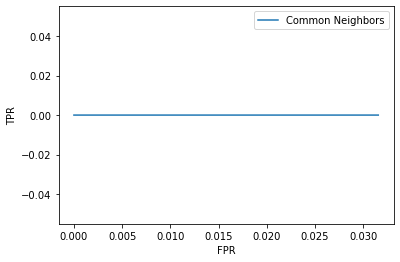

In [32]:
plt.plot(cn_evaluation.fallout(), cn_evaluation.recall(), label="Common Neighbors")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend()
plt.show()

In [ ]:
aa_evaluation = linkpred.evaluation.EvaluationSheet(aa_results, test, universe)

In [ ]:
jc_evaluation = linkpred.evaluation.EvaluationSheet(jc_results, test, universe)

In [ ]:
plt.plot(cn_evaluation.fallout(), cn_evaluation.recall(), label="Common Neighbors")
plt.plot(aa_evaluation.fallout(), aa_evaluation.recall(), label="Adamic Adar")
plt.plot(jc_evaluation.fallout(), jc_evaluation.recall(), label="Jaccard")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend()
plt.show()

In [ ]:


print("Area Under Roc Curve (AUROC)")
print(f"Common Neigh.: \t {auc(cn_evaluation.fallout(), cn_evaluation.recall())}")
print(f"Adamic Adar: \t {auc(aa_evaluation.fallout(), aa_evaluation.recall())}")
print(f"Jaccard: \t {auc(jc_evaluation.fallout(), jc_evaluation.recall())}")